### Methods for minimization with linear equality constraints
- Newton method requiring feasible start point
- Newton method allowing infeasible start point

### Methods for minimization with general inequality constraints
- Iterated interior point (barrier) method using BFGS or Newton method
- Primal-dual interior point (barrier) method

In [2]:
import autograd.numpy as np
from autograd import grad as auto_grad, jacobian as auto_jacobian
import scipy

import matplotlib.pyplot as plt
import seaborn

In [3]:
def solve_square_with_qr(A, b):
    """Solve system of equations with square (real values) matrix A: A * x = b"""""
    Q, R = np.linalg.qr(A)
    x = scipy.linalg.solve_triangular(R, Q.T @ b)
    return x


def solve_symm_with_chol(A, b):
    """Solve system of equations with symmetric (hermitian) matrix A: A * x = b"""""
    c, lower = scipy.linalg.cho_factor(A)
    x = scipy.linalg.cho_solve((c, lower), b)
    return x

In [77]:
n0 = 1
def objective_fn0(x):
    y = - x[..., 0]**2
    return y

def eq_constraint_fn0(x):
    c0 = x[..., 0] - 1
    return np.array([c0])

grad_fn0 = auto_grad(objective_fn0)
hessian_fn0 = auto_jacobian(grad_fn0)
jacobian_eq_cnst0 = auto_jacobian(eq_constraint_fn0)

n1 = 2
def objective_fn1(x):
    y = x[..., 0]**2 + x[..., 1]**2
    return y

def eq_constraint_fn1(x):
#     c0 = x[..., 0]**2 + x[..., 1]**2 - 1
#     return np.array([c0])
#     c0 = x[..., 0]**2 - x[..., 1] - 1
#     return np.array([c0])
    c0 = 3*x[..., 0] - x[..., 1] - 1
    return np.array([c0])

grad_fn1 = auto_grad(objective_fn1)
hessian_fn1 = auto_jacobian(grad_fn1)
jacobian_eq_cnst1 = auto_jacobian(eq_constraint_fn1)


"""Objectives with inequality constraints"""

n1 = 1
def objective_fn2(x):
    y = - x[..., 0]**2
    return y

# Constraints as c <= 0
def constraint2_1(x):
    c = x[..., 0]**2 - 1
#     c = np.sqrt((x[..., 0] - 1)**2) - 0.5
    return np.array([c])

grad_fn2 = auto_grad(objective_fn2)
hessian_fn2 = auto_jacobian(grad_fn2)
constraints2 = [constraint2_1]
grad_constraints2 = [auto_grad(constraint) for constraint in constraints2]
hessian_constraints2 = [auto_jacobian(grad_cnst) for grad_cnst in grad_constraints2]


n1 = 2
def objective_fn3(x):
    y = x[..., 0]**2 + x[..., 1]**2
    return y


# Constraints as c <= 0

def constraint3_1(x):
    c = x[..., 0] + 1
    return np.array([c])

def constraint3_2(x):
    c = - x[..., 1] + 2
    return np.array([c])

grad_fn3 = auto_grad(objective_fn3)
hessian_fn3 = auto_jacobian(grad_fn3)
constraints3 = [constraint3_1, constraint3_2]
grad_constraints3 = [auto_grad(constraint) for constraint in constraints3]
hessian_constraints3 = [auto_jacobian(grad_cnst) for grad_cnst in grad_constraints3]

In [78]:
def min_newton_method_eq_constraint_feasible(objective_fn, grad_fn, hessian_fn,
                                             eq_constraint_fn, jacobian_eq_cnst_fn, x0,
                                             alpha_min=1e-6, alpha_max=1e6,
                                             obj_tol=1e-15, cnst_tol=1e-15, max_iterations=10**6):
    """Minimize non-linear function with linear equality constraints.
    The initial point 'x0' has to be feasible."""

    assert np.abs(eq_constraint_fn(x0)) < cnst_tol, \
        "The initial point has to be feasible ({} is above tolerance {})".format(
            np.abs(constraint_fn(x0)), cnst_tol)

    num_vars = x0.shape[0]
    num_eq_cnst = eq_constraint_fn(x0).shape[0]
    if x0.ndim == 1:
        x0 = x0[:, np.newaxis]

    x = np.array(x0)
    iteration = 0
    dobj = float("inf")
    obj_value = objective_fn(x[:, 0])
    while np.abs(dobj) > obj_tol and iteration < max_iterations:
        prev_obj_value = obj_value
        grad = grad_fn(x[:, 0])[:, np.newaxis]
        jacobian_eq_cnst = jacobian_eq_cnst_fn(x[:, 0])
        eq_constraint = eq_constraint_fn(x[:, 0])[:, np.newaxis]
        hessian = hessian_fn(x[:, 0])

        # Generate newton system
        A_upper = np.block([[hessian, jacobian_eq_cnst.T]])
        A_lower = np.block([[jacobian_eq_cnst, np.zeros((num_eq_cnst, num_eq_cnst))]])
        A = np.concatenate((A_upper, A_lower), axis=0)
        b = np.concatenate((-grad, np.zeros((num_eq_cnst, 1))), axis=0)
        # Solve for step direction.
        # This is usually the main computational burden so should be
        # an efficient method depending on structure of A.
        y = np.linalg.solve(A, b)
        step_dir = y[:num_vars, :]
        # Lagrange variables
        nu = y[num_vars:, :]

        # Backtracking line-search
        alpha = alpha_max
        x_next = x
        dobj = float("inf")
        while dobj >= 0 and alpha >= alpha_min:
            step = alpha * step_dir
            x_next = x + step
            obj_value = objective_fn(x_next[:, 0])
            dobj = obj_value - prev_obj_value
            alpha *= 0.5
        iteration += 1

        if dobj >= 0:
            break
        x = x_next

    obj_value = objective_fn(x[:, 0])
    eq_constraint_value = eq_constraint_fn(x[:, 0])
    info = {
        "obj_value": obj_value,
        "eq_constraint_value": eq_constraint_value,
        "iteration": iteration,
        "max_iterations": max_iterations,
        "nu": nu,
    }
    x = x[:, 0]
    return x, info

In [79]:
def min_newton_method_eq_constraint(objective_fn, grad_fn, hessian_fn,
                                    eq_constraint_fn, jacobian_eq_cnst_fn,
                                    x0, nu0=None,
                                    eps=1e-15, r_tol=1e-15, cnst_tol=1e-15, max_iterations=10**6):
    num_vars = x0.shape[0]
    num_eq_cnst = eq_constraint_fn(x0).shape[0]
    if nu0 is None:
        nu0 = np.zeros((num_eq_cnst, 1))
    alpha = 0.25
    beta = 0.5
    if x0.ndim == 1:
        x0 = x0[:, np.newaxis]
    if nu0.ndim == 1:
        nu0 = nu0[:, np.newaxis]

    x = np.array(x0)
    nu = np.array(nu0)
    iteration = 0
    while iteration < max_iterations:
        grad = grad_fn(x[:, 0])[:, np.newaxis]
        jacobian_eq_cnst = jacobian_eq_cnst_fn(x[:, 0])
        eq_constraint = eq_constraint_fn(x[:, 0])[:, np.newaxis]
        hessian = hessian_fn(x[:, 0])

        # Generate newton system
        A_upper = np.block([[hessian, jacobian_eq_cnst.T]])
        A_lower = np.block([[jacobian_eq_cnst, np.zeros((num_eq_cnst, num_eq_cnst))]])
        A = np.concatenate((A_upper, A_lower), axis=0)
        b = np.concatenate((-grad + jacobian_eq_cnst.T @ nu, -eq_constraint), axis=0)
        # Solve for step direction.
        # This is usually the main computational burden so should be
        # an efficient method depending on structure of A.
        dy = np.linalg.solve(A, b)
        dx = dy[:num_vars, :]
        dnu = dy[num_vars:, :]
        print("dx:", dx, ", dnu:", dnu)

        def r(x, nu):
            return np.concatenate(
                (grad_fn(x[:, 0])[:, np.newaxis] + jacobian_eq_cnst_fn(x[:, 0]).T @ nu,
                 eq_constraint_fn(x[:, 0])[:, np.newaxis]),
                axis=0)

        # Line search on newton decrement
        t = 1.
        r_value1 = r(x, nu)
        r_norm1 = np.linalg.norm(r_value1)
        while True:
            r_value2 = r(x + t * dx, nu + t * dnu)
            r_norm2 = np.linalg.norm(r_value2)
            if r_norm2 <= (1 - alpha * t) * r_norm1:
                break
            t *= beta
        x += t * dx
        nu += t * dnu
        iteration += 1

        if r_norm2 <= r_tol and np.abs(eq_constraint_fn(x[:, 0])) <= cnst_tol:
            break
        if np.linalg.norm(t * dx) <= eps and np.linalg.norm(t * dy) <= eps:
            break


    obj_value = objective_fn(x[:, 0])
    eq_constraint_value = eq_constraint_fn(x[:, 0])
    info = {
        "obj_value": obj_value,
        "eq_constraint_value": eq_constraint_value,
        "r_value": r_value2,
        "iteration": iteration,
        "max_iterations": max_iterations,
        "t": t,
        "nu": nu[:, 0],
    }
    x = x[:, 0]
    return x, info

dx: [[-4.]] , dnu: [[2.]]
minimum x: [1.]
objective value: -1.0
equality constraint value: [0.]
iteration: 1


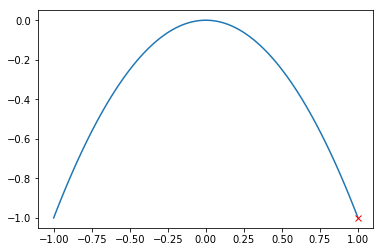

In [80]:
# Minimize function #0 with newton method
x0 = np.array([5.])
max_iterations = 10
x_min, info = min_newton_method_eq_constraint(objective_fn0, grad_fn0, hessian_fn0,
                                              eq_constraint_fn0, jacobian_eq_cnst0, x0,
                                              max_iterations=max_iterations)
print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("equality constraint value: {}".format(info["eq_constraint_value"]))
# print("r_value: {}".format(info["r_value"]))
print("iteration: {}".format(info["iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min), +np.abs(x_min), 100)[:, np.newaxis]
plt.plot(x, objective_fn0(x))
plt.plot([x_min], [objective_fn0(x_min)], 'rx')
plt.show()

Constraint value of initial point: [-4995.]
dx: [[-1.7000e+00]
 [-5.0001e+03]] , dnu: [[-0.2]]
dx: [[1.21180843e-13]
 [3.63764574e-13]] , dnu: [[-0.4]]
minimum x: [ 0.3 -0.1]
objective value: 0.10000000000000005
equality constraint value: [2.22044605e-16]
iteration: 2


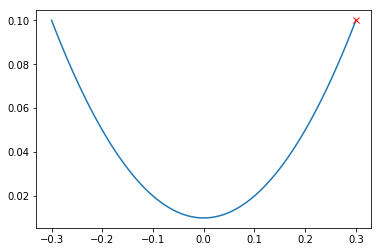

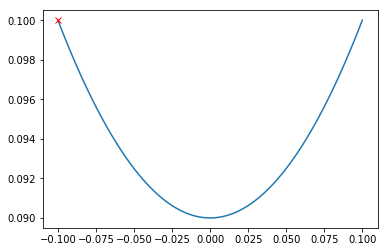

In [81]:
# Minimize function #1 with newton method
x0 = np.array([2., 5.])
x0 = np.array([2., 5000.])
# x0 = np.array([2., 0.])
print("Constraint value of initial point:", eq_constraint_fn1(x0))
max_iterations = 10
x_min, info = min_newton_method_eq_constraint(
    objective_fn1, grad_fn1, hessian_fn1,
    eq_constraint_fn1, jacobian_eq_cnst1, x0,
    max_iterations=max_iterations)
print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("equality constraint value: {}".format(info["eq_constraint_value"]))
# print("r_value: {}".format(info["r_value"]))
print("iteration: {}".format(info["iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min[0]), +np.abs(x_min[0]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn1(np.array([v, x_min[1]])) for v in x])
plt.plot([x_min[0]], [objective_fn1(x_min)], 'rx')
plt.show()

plt.figure()
x = np.linspace(-np.abs(x_min[1]), +np.abs(x_min[1]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn1(np.array([x_min[0], v])) for v in x])
plt.plot([x_min[1]], [objective_fn1(x_min)], 'rx')
plt.show()

minimum x: [ 0.30010183 -0.09969452]
objective value: 0.10000010368971377
equality constraint value: [-1.66533454e-15]
iteration: 100


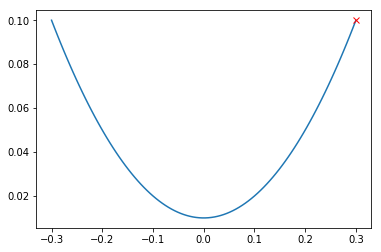

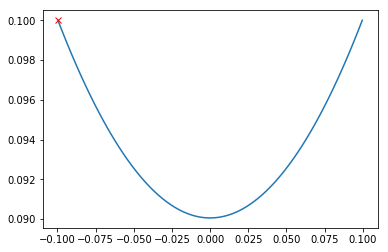

In [9]:
# Minimize function #1 with newton method starting from feasible point
x0 = np.array([2., 5.])
max_iterations = 100
x_min, info = min_newton_method_eq_constraint_feasible(
    objective_fn1, grad_fn1, hessian_fn1,
    eq_constraint_fn1, jacobian_eq_cnst1,
    x0, max_iterations=max_iterations)
print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("equality constraint value: {}".format(info["eq_constraint_value"]))
print("iteration: {}".format(info["iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min[0]), +np.abs(x_min[0]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn1(np.array([v, x_min[1]])) for v in x])
plt.plot([x_min[0]], [objective_fn1(x_min)], 'rx')
plt.show()

plt.figure()
x = np.linspace(-np.abs(x_min[1]), +np.abs(x_min[1]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn1(np.array([x_min[0], v])) for v in x])
plt.plot([x_min[1]], [objective_fn1(x_min)], 'rx')
plt.show()

In [10]:
def min_newton_method(objective_fn, grad_fn, hessian_fn, x0,
                      t_min=1e-6, eps=1e-15, obj_tol=1e-15, max_iterations=10**6,
                      verbose=False):
    x = np.array(x0)
    t = 1.
    iteration = 0
    dobj = float("inf")
    obj_value = objective_fn(x)
    print(obj_value, iteration, dobj, obj_tol)
    while np.abs(dobj) > obj_tol and iteration < max_iterations:
        if verbose:
            print("iteration:", iteration)
            print("  x:", x)
        prev_obj_value = obj_value
        grad = grad_fn(x)
        hessian = hessian_fn(x)
        if verbose:
            print("  grad:", grad)
            print("  hessian:", hessian)

        # Compute step direction (+ simple method for Hessian modification)
        hessian_mod_factor = 1
        hessian_mod = hessian
        positive_definite = False
        while not positive_definite:
            try:
                # Cholesky factorization will fail if hessian not positive definite
                step = solve_symm_with_chol(hessian_mod, -grad)
                positive_definite = True
            except np.linalg.LinAlgError as exc:
                # In that case we add a multiple of the identity matrix
                hessian_mod = hessian + hessian_mod_factor * np.eye(hessian.shape[0])
                # And increase factor if still not positive definite
                hessian_mod_factor *= 2
        if verbose:
            print("  hessian_mod:", hessian_mod)
            print("  step:", step)

        newton_decrement_square = - grad.T @ step
        print(grad, step, newton_decrement_square)
        if newton_decrement_square * 0.5 < eps:
            if verbose:
                print("Newton decrement below threshold")
            break

        # Backtracking line search
        t = 1.
        x_next = x
        dobj = float("inf")
        while dobj > 0 and t >= t_min:
            x_next = x + t * step
            obj_value = objective_fn(x_next)
            dobj = obj_value - prev_obj_value
            t *= 0.5
        if verbose:
            print("Line search stopped with t={}, x_next={}, dobj={}, obj_value={}".format(
                t, x_next, dobj, obj_value))
        x = x_next
        iteration += 1
    info = {
        "obj_value": obj_value,
        "dobj": dobj,
        "obj_tol": obj_tol,
        "iteration": iteration,
        "max_iterations": max_iterations,
        "grad": grad,
        "hessian": hessian,
        "hessian_mod": hessian_mod,
        "t": t,
        "step": step,
    }
    return x, info

In [11]:
def min_bfgs(objective_fn, grad_fn, x0,
             t_min=1e-6, eps=1e-15, obj_tol=1e-15, beta=0.5, c=0.0001,
             max_iterations=10**6, verbose=False):
    x = np.array(x0)
    # Initialize inverse Hessian approximation
    B_inv = np.eye(x.shape[-1])
    t = None
    step = None
    iteration = 0
    dobj = float("inf")
    obj_value = objective_fn(x)
    while np.abs(dobj) > obj_tol and iteration < max_iterations:
        if verbose:
            print("iteration:", iteration)
        prev_obj_value = obj_value
        grad = grad_fn(x)
        if verbose:
            print("  grad:", grad)
            print("  B_inv:", B_inv)

        # Simple method for Hessian modification (faster methods available)
        hessian_mod_factor = 1
        B_inv_mod = B_inv
        positive_definite = False
        while not positive_definite:
            try:
                # Cholesky factorization will fail if hessian not positive definite
                scipy.linalg.cho_factor(B_inv_mod)
                positive_definite = True
            except np.linalg.LinAlgError as exc:
                # In that case we add a multiple of the identity matrix
                B_inv_mod = B_inv + hessian_mod_factor * np.eye(B_inv.shape[0])
                # And increase factor if still not positive definite
                hessian_mod_factor *= 2

        step_dir = -B_inv_mod @ grad
        if verbose:
            print("  step_dir:", step_dir)

        newton_decrement_square = - grad.T @ step_dir
        if newton_decrement_square * 0.5 < eps:
            if verbose:
                print("Newton decrement below threshold")
            break

        t = 1.
        x_next = x
        grad_norm = np.linalg.norm(grad)
        while t >= t_min:
            step = t * step_dir
            x_next = x + step
            obj_value = objective_fn(x_next)
            dobj = obj_value - prev_obj_value
            # Armijo-Goldstein inequality
            if dobj <= - c * t * grad_norm:
                break
            t *= beta
        x = x_next
        step = step[..., np.newaxis]

        # Update inverse Hessian approximation
        y = (grad_fn(x) - grad)[..., np.newaxis]
        B_inv_step1_nom = (step.T @ y + y.T @ B_inv @ y) * (step @ step.T)
        B_inv_step1_denom = (step.T @ y) ** 2
        B_inv_step1 = B_inv_step1_nom / B_inv_step1_denom
        B_inv_step2 = - (B_inv @ y @ step.T + step @ y.T @ B_inv) / (step.T @ y)
        B_inv += B_inv_step1 + B_inv_step2

        iteration += 1
    info = {
        "obj_value": obj_value,
        "dobj": dobj,
        "obj_tol": obj_tol,
        "iteration": iteration,
        "max_iterations": max_iterations,
        "grad": grad,
        "t": t,
        "step_dir": step_dir,
        "step": step,
        "B_inv": B_inv,
    }
    return x, info

In [12]:
def min_interior_point_barrier(obj_fn, grad_fn, hessian_fn,
                               constraints, grad_constraints, hessian_constraints,
                               x0, max_iterations=1000, t0=0.01, t_factor=10., eps=1e-12, cnst_tol=1e-300,
                               use_bfgs=True, verbose=False):

    if len(constraints) == 0:
        if use_bfgs:
            return min_bfgs(obj_fn, grad_fn, x0, max_iterations=max_iterations)
        else:
            return min_newton_method(obj_fn, grad_fn, hessian_fn, x0, max_iterations=max_iterations)

    for i, constraint_fn in enumerate(constraints):
        cnst = constraint_fn(x0)
        assert cnst <= -cnst_tol, \
            "The initial point has to be feasible for constraint {} ({} is above tolerance {})".format(
                i, np.abs(cnst), cnst_tol)

    def fun_with_barrier(x, t):
        barrier = 0
        for constraint_fn in constraints:
            cnst = constraint_fn(x)
            if cnst >= -cnst_tol:
                return float("inf")
            barrier += - np.log(-cnst)
        y = obj_fn(x) + 1 / t * barrier
        return y

    def grad_with_barrier(x, t):
        barrier_grad = 0
        for constraint_fn, grad_constraint_fn in zip(constraints, grad_constraints):
            cnst = constraint_fn(x)
            grad_cnst = grad_constraint_fn(x)
            barrier_grad += - (1 / cnst) * grad_cnst
        grad = grad_fn(x) + 1 / t * barrier_grad
        return grad

    if not use_bfgs:
        def hessian_with_barrier(x, t):
            barrier_hessian = 0
            for constraint_fn, grad_constraint_fn, hessian_constraint_fn \
            in zip(constraints, grad_constraints, hessian_constraints):
                cnst = constraint_fn(x)
                grad_cnst = grad_constraint_fn(x)
                hessian_cnst = hessian_constraint_fn(x)
                barrier_hessian += (1 / cnst**2) * grad_cnst[..., np.newaxis] @ grad_cnst[..., np.newaxis].T
                barrier_hessian += - (1 / cnst**2) * hessian_cnst
            hessian = hessian_fn(x) + 1 / t * barrier_hessian
            return hessian

    x = x0
    t = t0
    m = len(constraints)
    outer_iteration = 0
    info = {}

    while m / t >= eps:
        if use_bfgs:
            x_min, new_info = min_bfgs(
                lambda x: fun_with_barrier(x, t),
                lambda x: grad_with_barrier(x, t),
                x, max_iterations=max_iterations, verbose=verbose)
        else:
            x_min, new_info = min_newton_method(
                lambda x: fun_with_barrier(x, t),
                lambda x: grad_with_barrier(x, t),
                lambda x: hessian_with_barrier(x, t),
                x, max_iterations=max_iterations, verbose=verbose)

        if not np.isfinite(new_info['obj_value']):
            if verbose:
                print("Objective value diverged. Stopping.")
            break
        if verbose:
            print("x_min:", x_min)
        x = x_min
        info = new_info
        t *= t_factor
        outer_iteration += 1

    info["outer_iteration"] = outer_iteration
    info["t_barrier"] = t
    return x, info

minimum x: [-1.0000127   2.00000205]
objective value: [5.00027732]
constraint values: [array([2.54015783e-05])]
iteration: 100
outer iterations: 8


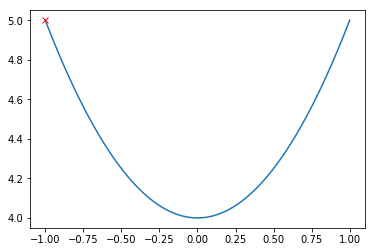

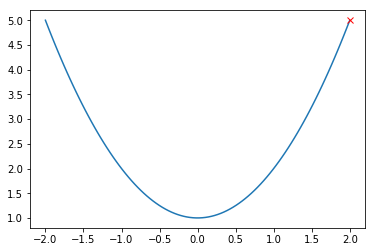

In [13]:
x0 = np.array([-200., 5.])
max_iterations = 100
x_min, info = min_interior_point_barrier(
    objective_fn3, grad_fn3, hessian_fn3,
    constraints3, grad_constraints3, hessian_constraints3,
    x0, max_iterations=max_iterations, verbose=False)

print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("constraint values: {}".format([constraint_fn(x_min) for constraint_fn in constraints2]))
print("iteration: {}".format(info["iteration"]))
print("outer iterations: {}".format(info["outer_iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min[0]), +np.abs(x_min[0]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn3(np.array([v, x_min[1]])) for v in x])
plt.plot([x_min[0]], [objective_fn3(x_min)], 'rx')
plt.show()

plt.figure()
x = np.linspace(-np.abs(x_min[1]), +np.abs(x_min[1]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn3(np.array([x_min[0], v])) for v in x])
plt.plot([x_min[1]], [objective_fn3(x_min)], 'rx')
plt.show()

minimum x: [0.99999983]
objective value: [-0.99999818]
constraint values: [array([-3.31530904e-07])]
iteration: 100


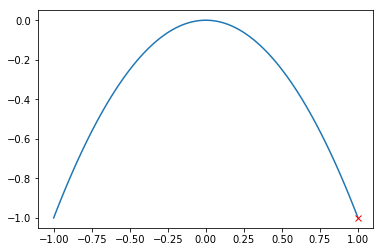

In [83]:
x0 = np.array([0.5])
max_iterations = 100
x_min, info = min_interior_point_barrier(
    objective_fn2, grad_fn2, hessian_fn2,
    constraints2, grad_constraints2, hessian_constraints2,
    x0, t0=10, max_iterations=max_iterations, verbose=False)

print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("constraint values: {}".format([constraint_fn(x_min) for constraint_fn in constraints2]))
print("iteration: {}".format(info["iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min[0]), +np.abs(x_min[0]), 100)[:, np.newaxis]
plt.plot(x, objective_fn2(x))
plt.plot([x_min[0]], [objective_fn2(x_min)], 'rx')
plt.show()

In [115]:
def min_interior_point_primal_dual(objective_fn, grad_fn, hessian_fn,
                                   constraints, grad_constraints, hessian_constraints,
                                   x0,
                                   Aeq=None, beq=None,
                                   u0=None, nu0=None,
                                   mu=10, alpha=0.5, beta=0.5, min_s=1e-15,
                                   eps=1e-15, r_tol=1e-15, cnst_tol=1e-15, max_iterations=10**6,
                                   verbose=False):

    num_vars = x0.shape[0]
    if Aeq is None:
        Aeq = np.zeros((0, num_vars))
    if beq is None:
        beq = np.zeros((0, 1))
    num_cnsts = len(constraints)
    num_eq_cnsts = Aeq.shape[0]
    if u0 is None:
        u0 = np.ones((num_cnsts, 1))
    if nu0 is None:
        nu0 = np.zeros((num_eq_cnsts, 1))
    alpha = 0.25
    beta = 0.5
    if x0.ndim == 1:
        x0 = x0[:, np.newaxis]
    if u0.ndim == 1:
        u0 = u0[:, np.newaxis]
    if nu0.ndim == 1:
        nu0 = nu0[:, np.newaxis]

    def r_fn(x, u, nu):
        tmp_grad = grad_fn(x[:, 0])[:, np.newaxis]
        tmp_cnsts = np.array([constraint_fn(x[:, 0]) for constraint_fn in constraints])
        tmp_grad_cnsts = np.vstack((grad_constraint_fn(x[:, 0]) for grad_constraint_fn in grad_constraints))
        r = np.concatenate(
            (tmp_grad + tmp_grad_cnsts.T @ u + Aeq.T @ nu,
             -np.diag(u.ravel()) @ tmp_cnsts - 1 / t,
             Aeq @ x - beq),
        axis=0)
#         if num_eq_cnsts == 0:
#             r = np.concatenate((r, np.zeros((1, 1))), axis=0)
        return r

    def eta_fn(x, u):
        tmp_cnsts = np.array([constraint_fn(x[:, 0]) for constraint_fn in constraints])
        eta = - tmp_cnsts.T @ u
        return eta

    x = np.array(x0)
    u = np.array(u0)
    nu = np.array(nu0)
    t = None
    s = None
    iteration = 0
    eta = eta_fn(x, u)
    while iteration < max_iterations:
        if verbose:
            print("iteration:", iteration)
            print("  x:", x, ", u:", u, ", nu:", nu)
        grad = grad_fn(x[:, 0])[:, np.newaxis]
        hessian = hessian_fn(x[:, 0])
        cnsts = np.array([constraint_fn(x[:, 0]) for constraint_fn in constraints])
        eq_constraints = Aeq @ x - beq
        grad_cnsts = np.vstack((grad_constraint_fn(x[:, 0]) for grad_constraint_fn in grad_constraints))

        t = mu * num_cnsts / eta
        if verbose:
            print("  t:", t)

        # Simple method for Hessian modification (faster methods available)
        hessian_mod_factor = 1
        hessian_mod = hessian
#         positive_definite = False
#         while not positive_definite:
#             try:
#                 # Cholesky factorization will fail if hessian not positive definite
#                 scipy.linalg.cho_factor(hessian_mod)
#                 positive_definite = True
#             except np.linalg.LinAlgError as exc:
#                 # In that case we add a multiple of the identity matrix
#                 hessian_mod = hessian + hessian_mod_factor * np.eye(hessian.shape[0])
#                 # And increase factor if still not positive definite
#                 hessian_mod_factor *= 2

        # Generate newton system
        A_upper = np.block([[hessian_mod, grad_cnsts.T, Aeq.T]])
        A_middle = np.block([[-np.diag(u.ravel()) @ grad_cnsts, -np.diag(cnsts.ravel()), np.zeros((num_cnsts, num_eq_cnsts))]])
        A_lower = np.block([[Aeq, np.zeros((num_eq_cnsts, num_cnsts)), np.zeros((num_eq_cnsts, num_eq_cnsts))]])
        A = np.concatenate((A_upper, A_middle, A_lower), axis=0)
#         b = np.concatenate(-(grad + grad_cnsts.T @ u + Aeq.T @ nu, -np.diag(u.ravel()) @ cnsts, -eq_constraints), axis=0)
        b = -r_fn(x, u, nu)
        # Solve for step direction.
        # This is usually the main computational burden so should be
        # an efficient method depending on structure of A.
        dy = np.linalg.solve(A, b)
        dx = dy[:num_vars, :]
        du = dy[num_vars:(num_vars+num_cnsts), :]
        dnu = dy[(num_vars+num_cnsts):, :]
        if verbose:
            print("  dx:", dx, ", du:", du, ", dnu:", dnu)

        # Line search for maximum s with u + s * du > 0
        s = 1.
        if np.any(du < 0):
            tmp_s = (-u / du)[du < 0]
            s = np.minimum(s, np.min(tmp_s))
        s = 0.99 * s
        if verbose:
            print("First line search found s={}".format(s))

        # Line search on residual
        r1 = r_fn(x, u, nu)
        r_norm1 = np.linalg.norm(r1)
        if verbose:
            print("  r_norm1:", r_norm1, ", r1:", r1)
        while s >= min_s:
            r2 = r_fn(x + s * dx, u + s * du, nu + s * dnu)
            r_norm2 = np.linalg.norm(r2)
            if verbose:
                print("  r_norm2:", r_norm2, ", r2:", r2)
            if r_norm2 <= (1 - alpha * s) * r_norm1:
                break
            s *= beta
        if verbose:
            print("Second line search found s={}, r_norm1={}, r_norm2={}".format(
                s, r_norm1, r_norm2))
        x += s * dx
        u += s * du
        nu += s * dnu
        iteration += 1

        eta = eta_fn(x, u)
        if verbose:
            print("  eta:", eta)
        r = r_fn(x, u, nu)
        if num_eq_cnsts == 0:
            r_prim_dual_norm = np.abs(r[0])
        else:
            r_prim_dual_norm = (r[0]**2 + r[2]**2)**0.5
        if eta <= eps and r_prim_dual_norm <= eps:
            if verbose:
                print("Minimization converged")
            break
#         if r_norm2 <= r_tol and np.abs(eq_constraint_fn(x[:, 0])) <= cnst_tol:
#             break
#         if np.linalg.norm(t * dx) <= eps and np.linalg.norm(t * dy) <= eps:
#             break


    obj_value = objective_fn(x[:, 0])
    constraint_value = np.array([constraint_fn(x_min) for constraint_fn in constraints])
    r = r_fn(x, u, nu)
    if num_eq_cnsts > 0:
        eq_constraint_value = Aeq @ x - beq
    else:
        eq_constraint_value = 0
    info = {
        "obj_value": obj_value,
        "constraint_value": constraint_value,
        "eq_constraint_value": eq_constraint_value,
        "r": r,
        "iteration": iteration,
        "max_iterations": max_iterations,
        "t": t,
        "s": s,
        "u": u[:, 0],
        "nu": nu[:, 0],
    }
    x = x[:, 0]
    return x, info

[-2000.]
iteration: 0
  x: [[-1000.]] , u: [[1.]] , nu: []
  t: [[-1.000001e-05]]
  dx: [[899.9982]] , du: [[0.8999982]] , dnu: []
First line search found s=0.99
  r_norm1: 899999.1 , r1: [[      0. ]
 [-899999.1]]
  r_norm2: 77534.34986600812 , r2: [[ -194.24078704]
 [77534.10655744]]
Second line search found s=0.99, r_norm1=899999.1, r_norm2=77534.34986600812
  eta: [[-22465.79344256]]
r.shape: (2, 1)
iteration: 1
  x: [[-109.001782]] , u: [[1.89099822]] , nu: []
  t: [[-0.00044512]]
  dx: [[31.76835534]] , du: [[-0.59955018]] , dnu: []
First line search found s=0.99
  r_norm1: 20220.147087403446 , r1: [[  -194.24078704]
 [-20219.2140983 ]]
  r_norm2: 5555.366871332167 , r2: [[  -46.13415324]
 [-5555.17530911]]
Second line search found s=0.99, r_norm1=20220.147087403446, r_norm2=5555.366871332167
  eta: [[-7801.75465337]]
r.shape: (2, 1)
iteration: 2
  x: [[-77.55111021]] , u: [[1.29744354]] , nu: []
  t: [[-0.00128176]]
  dx: [[42.30458486]] , du: [[0.24806232]] , dnu: []
First line

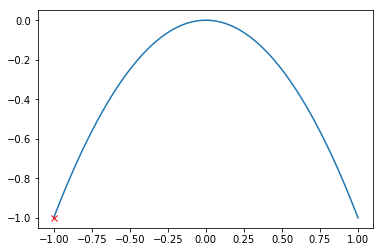

In [90]:
x0 = np.array([-1000.])
print(grad_constraints2[0](x0))
# print(grad_constraints2[1](x0))
max_iterations = 100
x_min, info = min_interior_point_primal_dual(
    objective_fn2, grad_fn2, hessian_fn2,
    constraints2, grad_constraints2, hessian_constraints2,
    x0, max_iterations=max_iterations, verbose=True)

print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("constraint values: {}".format(info["constraint_value"]))
print("equality constraint value: {}".format(info["eq_constraint_value"]))
print("iteration: {}".format(info["iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min[0]), +np.abs(x_min[0]), 100)[:, np.newaxis]
plt.plot(x, objective_fn2(x))
plt.plot([x_min[0]], [objective_fn2(x_min)], 'rx')
plt.show()

[-4.]
[-3.]
iteration: 0
  x: [[-5.]
 [ 5.]] , u: [[1.]
 [1.]] , nu: []
  t: [[2.85714286]]
  dx: [[ 4.40555556]
 [-4.23571429]] , du: [[0.18888889]
 [0.52857143]] , dnu: []
First line search found s=0.99
  r_norm1: 13.50351806012048 , r1: [[-9.  ]
 [ 9.  ]
 [ 3.65]
 [ 2.65]]
  r_norm2: 2.3070886409979776 , r2: [[-0.09      ]
 [ 0.09      ]
 [-0.7791005 ]
 [-2.16782389]]
Second line search found s=0.99, r_norm1=13.50351806012048, r_norm2=2.3070886409979776
  eta: [[-2.24692439]]
iteration: 1
  x: [[-0.6385    ]
 [ 0.80664286]] , u: [[1.187     ]
 [1.52328571]] , nu: []
  t: [[-8.90105609]]
  dx: [[-0.75277862]
 [-2.09962917]] , du: [[ 1.59555724]
 [-4.10925833]] , dnu: []
First line search found s=0.3669890611374247
  r_norm1: 1.739306572052754 , r1: [[-0.09      ]
 [ 0.09      ]
 [-0.31675428]
 [-1.70547767]]
  r_norm2: 0.12160269968952822 , r2: [[-0.05697098]
 [ 0.05697098]
 [-0.03874342]
 [ 0.08243044]]
Second line search found s=0.3669890611374247, r_norm1=1.739306572052754, r_norm

  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819897e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819897e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819897e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
Second line search found s=9.462873948143285e-16, r_norm1=6.720052975819897e-05, r_norm2=6.720052975819897e-05
  eta: [[7.05866728e-05]]
iteration: 20
  x: [[-1.00003529e+00]
 [ 9.19800581e-07]] , u: [[2.00006874e+00]
 [4.30138178e-19]] , nu: []
  t: [[283339.6050322]]
  dx: [[ 3.35263665e-05]
 [-1.8021

  r_norm2: 6.720052975819892e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819893e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819897e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
Second line search found s=9.06802607828371e-16, r_norm1=6.7200529758198

  r_norm1: 6.720052975819896e-05 , r1: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819892e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819893e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e

 [-1.76466763e-06]] , dnu: []
First line search found s=2.1650261820976585e-13
  r_norm1: 6.720052975819896e-05 , r1: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819892e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819893e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364

  t: [[283339.6050322]]
  dx: [[ 3.35263665e-05]
 [-1.80213440e-06]] , du: [[-6.52131318e-05]
 [-1.76466763e-06]] , dnu: []
First line search found s=2.090828282941266e-13
  r_norm1: 6.720052975819896e-05 , r1: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819892e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819893e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720

 [ 9.19800581e-07]] , u: [[2.00006874e+00]
 [3.59916126e-19]] , nu: []
  t: [[283339.6050322]]
  dx: [[ 3.35263665e-05]
 [-1.80213440e-06]] , du: [[-6.52131318e-05]
 [-1.76466763e-06]] , dnu: []
First line search found s=2.019173229818212e-13
  r_norm1: 6.720052975819896e-05 , r1: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819892e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819893e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 

iteration: 75
  x: [[-1.00003529e+00]
 [ 9.19800581e-07]] , u: [[2.00006874e+00]
 [3.47581392e-19]] , nu: []
  t: [[283339.6050322]]
  dx: [[ 3.35263665e-05]
 [-1.80213440e-06]] , du: [[-6.52131318e-05]
 [-1.76466763e-06]] , dnu: []
First line search found s=1.9499738765151573e-13
  r_norm1: 6.720052975819896e-05 , r1: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819892e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819893e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975

  r_norm2: 6.720052975819896e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
Second line search found s=7.384596931172049e-16, r_norm1=6.720052975819896e-05, r_norm2=6.720052975819896e-05
  eta: [[7.05866728e-05]]
iteration: 84
  x: [[-1.00003529e+00]
 [ 9.19800581e-07]] , u: [[2.00006874e+00]
 [3.35669384e-19]] , nu: []
  t: [[283339.6050322]]
  dx: [[ 3.35263665e-05]
 [-1.80213440e-06]] , du: [[-6.52131318e-05]
 [-1.76466763e-06]] , dnu: []
First line search found s=1.8831460634181855e-13
  r_norm1: 6.720052975819896e-05 , r1: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819892e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819893e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
 

  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819894e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
Second line search found s=7.131518431271945e-16, r_norm1=6.720052975819894e-05, r_norm2=6.720052975819894e-05
  eta: [[7.05866728e-05]]
iteration: 93
  x: [[-1.00003529e+00]
 [ 9.19800581e-07]] , u: [[2.00006874e+00]
 [3.24165614e-19]] , nu: []
  t: [[283339.6050322]]
  dx: [[ 3.35263665e-05]
 [-1.80213440e-06]] , du: [[-6.52131318e-05]
 [-1.76466763e-06]] , dnu: []
First line search found s=1.81860851515866e-13
  r_norm1: 6.720052975819894e-05 , r1: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.72005297581989e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_norm2: 6.720052975819892e-05 , r2: [[-1.83960116e-06]
 [ 1.83960116e-06]
 [ 6.70573392e-05]
 [-3.52933364e-06]]
  r_

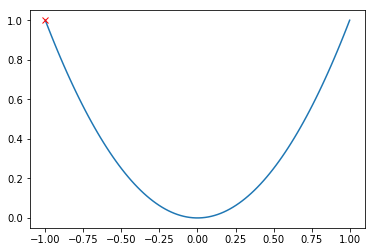

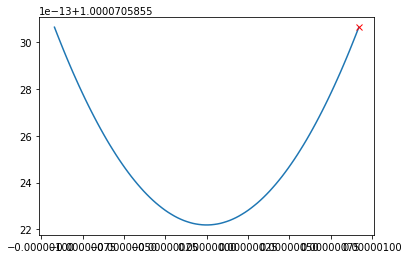

In [119]:
x0 = np.array([-5., 5.])
print(constraints3[0](x0))
print(constraints3[1](x0))
max_iterations = 100
x_min, info = min_interior_point_primal_dual(
    objective_fn3, grad_fn3, hessian_fn3,
    constraints3, grad_constraints3, hessian_constraints3,
    x0, max_iterations=max_iterations, verbose=True)

print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("constraint values: {}".format(info["constraint_value"]))
print("equality constraint value: {}".format(info["eq_constraint_value"]))
print("iteration: {}".format(info["iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min[0]), +np.abs(x_min[0]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn3(np.array([v, x_min[1]])) for v in x])
plt.plot([x_min[0]], [objective_fn3(x_min)], 'rx')
plt.show()

plt.figure()
x = np.linspace(-np.abs(x_min[1]), +np.abs(x_min[1]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn3(np.array([x_min[0], v])) for v in x])
plt.plot([x_min[1]], [objective_fn3(x_min)], 'rx')
plt.show()